## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

../camera_cal/calibration13.jpg
../camera_cal/calibration3.jpg
../camera_cal/calibration19.jpg
../camera_cal/calibration15.jpg
../camera_cal/calibration9.jpg
../camera_cal/calibration7.jpg
../camera_cal/calibration14.jpg
../camera_cal/calibration5.jpg
../camera_cal/calibration20.jpg
../camera_cal/calibration11.jpg
../camera_cal/calibration10.jpg
../camera_cal/calibration17.jpg
../camera_cal/calibration6.jpg
../camera_cal/calibration16.jpg
../camera_cal/calibration1.jpg
../camera_cal/calibration8.jpg
../camera_cal/calibration4.jpg
../camera_cal/calibration18.jpg
../camera_cal/calibration12.jpg
../camera_cal/calibration2.jpg


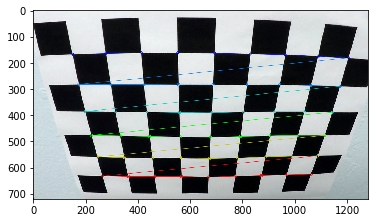

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(fname)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)   

## Apply distortion correction

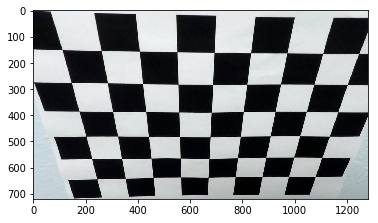

In [7]:
img = cv2.imread(images[-1])        
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

## Use color transformations